In [1]:
import sys
import time
import torch
import torch.nn as nn
import numpy as np
import os

sys.path.append('/home/agajan/DeepMRI')
from deepmri import Datasets, utils  # noqa: E402
from DiffusionMRI.AxialConv2dAE import ConvEncoder as Encoder64 # noqa: E402
from DiffusionMRI.AxialConv2dAE import ConvDecoder as Decoder64 # noqa: E402
from DiffusionMRI.AxialConv2dAE128 import ConvEncoder as Encoder128 # noqa: E402
from DiffusionMRI.AxialConv2dAE128 import ConvDecoder as Decoder128 # noqa: E402
%load_ext autoreload
%autoreload 2

In [2]:
# gpu settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # set False whenever input size varies
print("Device: ", device)

Device:  cuda:0


In [6]:
criterion = nn.MSELoss()

# Model 64
enc64 = Encoder64(input_channels=288)
enc64.to(device)

dec64 = Decoder64(out_channels=288)
dec64.to(device)

# load pretrained weights
enc64_path = '/home/agajan/DeepMRI/DiffusionMRI/models/axial_conv2d_encoder_epoch_1200'
dec64_path = '/home/agajan/DeepMRI/DiffusionMRI/models/axial_conv2d_decoder_epoch_1200'
enc64.load_state_dict(torch.load(enc64_path))
dec64.load_state_dict(torch.load(dec64_path))
enc64.eval()
dec64.eval()

p1 = utils.count_model_parameters(enc64)
p2 = utils.count_model_parameters(dec64)
print("Total parameters: {}, trainable parameters: {}".format(p1[0] + p2[0], p1[1] + p2[1]))

# Model 128
enc128 = Encoder128(input_channels=288)
enc128.to(device)

dec128 = Decoder128(out_channels=288)
dec128.to(device)

#load pretrained weights
enc128_path = '/home/agajan/DeepMRI/DiffusionMRI/models/axial_conv2d_128_encoder_epoch_1200'
dec128_path = '/home/agajan/DeepMRI/DiffusionMRI/models/axial_conv2d_128_decoder_epoch_1200'
enc128.load_state_dict(torch.load(enc128_path))
dec128.load_state_dict(torch.load(dec128_path))


# Overfitted Model 128
enc128_ovfit = Encoder128(input_channels=288)
enc128_ovfit.to(device)

dec128_ovfit = Decoder128(out_channels=288)
dec128_ovfit.to(device)

enc128_ovfit_path = '/home/agajan/DeepMRI/DiffusionMRI/models/ovfit_axial_conv2d_128_encoder_epoch_4700'
dec128_ovfit_path = '/home/agajan/DeepMRI/DiffusionMRI/models/ovfit_axial_conv2d_128_decoder_epoch_4700'
enc128_ovfit.load_state_dict(torch.load(enc128_ovfit_path))
dec128_ovfit.load_state_dict(torch.load(dec128_ovfit_path))
enc128_ovfit.eval()
dec128_ovfit.eval()

p1 = utils.count_model_parameters(enc128)
p2 = utils.count_model_parameters(dec128)
print("Total parameters: {}, trainable parameters: {}".format(p1[0] + p2[0], p1[1] + p2[1]))

Total parameters: 129920, trainable parameters: 129920
Total parameters: 2573824, trainable parameters: 2573824


In [9]:
# training data settings
mu = 383
std = 828
batch_size = 16

data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/data/train/'
dataset = Datasets.OrientationDataset(data_path + 'axial/', mu=mu, std=std, normalize=False, debug=True)
print("Total training examples: ", len(dataset))

Total training examples:  598


Data idx: 107, time: 91
/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/data/train/axial/data_156334_axial_idx_86.npz


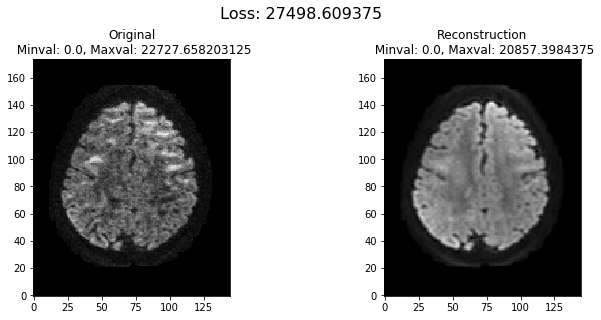

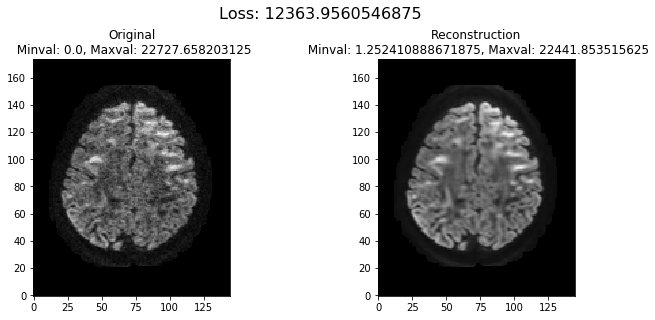

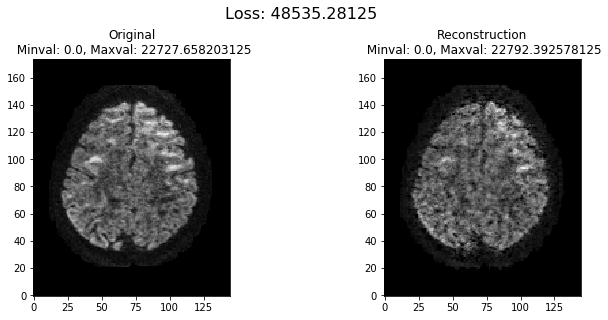

In [11]:
idx = np.random.randint(low=0, high=len(dataset))
t = np.random.randint(low=0, high=288)
print("Data idx: {}, time: {}".format(idx, t))
x = dataset[idx]
x = x.numpy().transpose(1, 2, 0)

enc64.eval()
dec64.eval()
enc128.eval()
dec128.eval()
enc128_ovfit.eval()

y, loss = utils.evaluate_ae(x, enc64, dec64, criterion, device, mu, std, t)
y, loss = utils.evaluate_ae(x, enc128, dec128, criterion, device, mu, std, t)
y, loss = utils.evaluate_ae(x, enc128_ovfit, dec128_ovfit, criterion, device, mu, std, t)